In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


Building the `train` object
==========

The job of the YAML parser is to instantiate the train object and everything inside of it. Looking at an example YAML file:

In [3]:
!cat yaml_templates/replicate_8aug_online.yaml

!obj:pylearn2.train.Train {
    dataset: &train !obj:neukrill_net.image_directory_dataset.ListDataset {
        transformer: !obj:neukrill_net.augment.RandomAugment {
                units: 'float',
                rotate: [0,90,180,270],
                rotate_is_resizable: 0,
                flip: 1,
                resize: %(final_shape)s,
                normalise: {global_or_pixel: 'global',
                            mu: %(mu)s,
                            sigma: %(sigma)s}
            },
        settings_path: %(settings_path)s,
        run_settings_path: %(run_settings_path)s
    },
    model: !obj:pylearn2.models.mlp.MLP {
        batch_size: &batch_size 128,
        input_space: !obj:pylearn2.space.Conv2DSpace {
            shape: %(final_shape)s,
            num_channels: 1,
            axes: ['b', 0, 1, 'c'],
        },
        layers: [ !obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: h1,
                     output_channels: 48,
           

We want to know how to build a model with parallel channels. So, we're going to look at interactively building just the model part of this specification and how it deals with different inputs. It should be possible to put the convolutional layers in parallel using a CompositeSpace as described in [this post on the pylearn-users][userspost]. It could be troublesome, however, supplying these layers with two data streams.

Building the model
----------------

Using the specification from above we can see how to instantiate an MLP class interactively. The obvious part we need to deal with first is the `input_space`. We have to define this to be a CompositeSpace ([documentation for spaces][spaces]). Seems like [this will involve modifying the dataset class][cspace], but as long as the tuple is in the right format it shouldn't be a problem.

[This post][p3] might also be useful, as they seem to be trying to do the same thing, and contains an example of how to defined the CompositeSpace. So, we should start by instantiating the [CompositeSpace][].

[spaces]: http://deeplearning.net/software/pylearn2/internal/data_specs.html
[compositespace]: http://deeplearning.net/software/pylearn2/library/space.html
[p3]: https://groups.google.com/forum/#!searchin/pylearn-users/compositespace/pylearn-users/eC4h8wuTvpQ/IvexomhvuC4J
[cspace]: https://groups.google.com/forum/#!searchin/pylearn-users/compositespace/pylearn-users/1P8JW7-nOnA/P35i3RCkq9YJ
[userspost]: https://groups.google.com/forum/#!searchin/pylearn-users/parallel$20layer/pylearn-users/654p2K_hAfw/Hfrezz_nB0oJ

In [4]:
import pylearn2.space

In [5]:
final_shape = (48,48)

In [6]:
input_space = pylearn2.space.CompositeSpace([
    pylearn2.space.Conv2DSpace(shape=final_shape,num_channels=1,axes=['b',0,1,'c']),
    pylearn2.space.Conv2DSpace(shape=final_shape,num_channels=1,axes=['b',0,1,'c'])
    ])

Composite Layers
--------------

Up until we reach the fully connected layers we want to have different convolutional pipelines. To do this, we have to define two of these pipelines inside a CompositeLayer.

In [7]:
import pylearn2.models.mlp

First, we have to instantiate two copies of the above convolutional layers as their own MLP objects. Originally, I thought these should have an `input_source` to specify the inputs they take, turns out __nested MLPs do not have input or target sources__. Might as well store these in a dictionary:

In [8]:
convlayers = {}
for i in range(2):
    convlayers[i] = pylearn2.models.mlp.MLP(
        layer_name="convlayer_{0}".format(i),
        batch_size=128,
        layers=[pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name='h1',
                output_channels=48,
                irange=0.025,
                init_bias=0,
                kernel_shape=[8,8],
                pool_shape=[2,2],
                pool_stride=[2,2],
                max_kernel_norm=1.9365
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name='h2',
                output_channels=96,
                irange=0.025,
                init_bias=0,
                kernel_shape=[5,5],
                pool_shape=[2,2],
                pool_stride=[2,2],
                max_kernel_norm=1.9365
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name='h3',
                output_channels=128,
                irange=0.025,
                init_bias=0,
                kernel_shape=[3,3],
                pool_shape=[2,2],
                pool_stride=[2,2],
                max_kernel_norm=1.9365
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name='h4',
                output_channels=128,
                irange=0.025,
                init_bias=0,
                kernel_shape=[3,3],
                pool_shape=[2,2],
                pool_stride=[2,2],
                max_kernel_norm=1.9365
                )
            ]
        )

Then we can initialise our CompositeLayer with these two stacks of convolutional layers. Have to define dictionary mapping which of the inputs in the composite space supplied goes to which component of the space.

In [9]:
inputs_to_layers = {0:[0],1:[1]}
compositelayer = pylearn2.models.mlp.CompositeLayer(
                            layer_name="parallel_conv",
                            layers=[convlayers[i] for i in range(2)],
                            inputs_to_layers=inputs_to_layers)

Unfortunately, it turns out we also have to put a FlattenerLayer around this so that the output of this layer will play nicely with the fully connected layer following this:

In [10]:
flattened = pylearn2.models.mlp.FlattenerLayer(raw_layer=compositelayer)

Now we need to connect this composite layer to the rest of the network, which is a single fully connected layer and the softmax output layer. To do this, we instantiate another MLP object, in which the first layer is this composite layer. This also when we use the composite input space we defined above.

In [11]:
n_classes=121

In [12]:
main_mlp =None

In [13]:
main_mlp = pylearn2.models.mlp.MLP(
        batch_size=128,
        input_space=input_space,
        input_source=['img_1','img_2'],
        layers=[
            flattened,
            pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                max_col_norm=1.9,
                layer_name='h5',
                istdev=0.05,
                W_lr_scale=0.25,
                b_lr_scale=0.25),
            pylearn2.models.mlp.Softmax(
                n_classes=121,
                max_col_norm=1.9365,
                layer_name='y',
                istdev=0.05,
                W_lr_scale=0.25,
                b_lr_scale=0.25
            )
        ]
    )

Input shape: (48, 48)
Detector space: (41, 41)
Output space: (21, 21)
Input shape: (21, 21)
Detector space: (17, 17)
Output space: (9, 9)
Input shape: (9, 9)
Detector space: (7, 7)
Output space: (4, 4)
Input shape: (4, 4)
Detector space: (2, 2)
Output space: (1, 1)
Input shape: (48, 48)
Detector space: (41, 41)
Output space: (21, 21)
Input shape: (21, 21)
Detector space: (17, 17)
Output space: (9, 9)
Input shape: (9, 9)
Detector space: (7, 7)
Output space: (4, 4)
Input shape: (4, 4)
Detector space: (2, 2)
Output space: (1, 1)


Creating the dataset
------------------

To test this model we need a dataset that's going to supply the input data in the correct format. This should be a tuple of 4D arrays returns by the iterator in the tuple containing the input and target batches. We can create this pretty easily by just making a Dataset that inherits our old ListDataset and creates an iterator that contains two FlyIterators.

In [14]:
import neukrill_net.image_directory_dataset
import copy

In [15]:
reload(neukrill_net.image_directory_dataset)

<module 'neukrill_net.image_directory_dataset' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/image_directory_dataset.pyc'>

In [16]:
class ParallelIterator(object):
    def __init__(self, *args, **keyargs):
        keyargs['rng'] = np.random.RandomState(42)
        self.iterator_1 = neukrill_net.image_directory_dataset.FlyIterator(*args,**keyargs)
        keyargs = copy.deepcopy(keyargs)
        keyargs['rng'] = np.random.RandomState(42)
        self.iterator_2 = neukrill_net.image_directory_dataset.FlyIterator(*args,**keyargs)
        self.stochastic=False
        self.num_examples = self.iterator_1.num_examples
        
    def __iter__(self):
        return self
    
    def next(self):
        # get a batch from both iterators:
        Xbatch1,ybatch1 = self.iterator_1.next()
        Xbatch2,ybatch2 = self.iterator_2.next()
        assert np.allclose(ybatch1,ybatch2)
        return Xbatch1,Xbatch2,ybatch1

In [17]:
class ParallelDataset(neukrill_net.image_directory_dataset.ListDataset):
    def iterator(self, mode=None, batch_size=None, num_batches=None, rng=None,
                data_specs=None, return_tuple=False):
        if not num_batches:
            num_batches = int(len(self.X)/batch_size)
        iterator = ParallelIterator(dataset=self, batch_size=batch_size,
                               num_batches=num_batches,
                               final_shape=self.run_settings["final_shape"],
                               rng=None,mode=mode)
        return iterator

In [18]:
import neukrill_net.augment
import os

In [19]:
dataset = ParallelDataset(
        transformer=neukrill_net.augment.RandomAugment(
            units='float',
            rotate=[0,90,180,270],
            rotate_is_resizable=0,
            flip=1,
            resize=final_shape,
            normalise={'global_or_pixel':'global',
                       'mu': 0.957,
                       'sigma': 0.142}
        ),
        settings_path=os.path.abspath("settings.json"),
        run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
        force=True
    )

Testing this new dataset iterator:

In [20]:
iterator = dataset.iterator(mode='even_shuffled_sequential',batch_size=128)

In [21]:
X1,X2,y = iterator.next()

Plotting some of the images it produces side by side to make sure they're the same:

Iterator_2
      I     : Image.Iterator 2   (z)
      II    : Image.Iterator 2   (z)
      III   : Image.Iterator 2   (z)
      IV    : Image.Iterator 2   (z)
      V     : Image.Iterator 2   (z)
      VI    : Image.Iterator 2   (z)
      VII   : Image.Iterator 2   (z)
      VIII  : Image.Iterator 2   (z)
      IX    : Image.Iterator 2   (z)
      X     : Image.Iterator 2   (z)
      XI    : Image.Iterator 2   (z)
      XII   : Image.Iterator 2   (z)
      XIII  : Image.Iterator 2   (z)
      XIV   : Image.Iterator 2   (z)
      XV    : Image.Iterator 2   (z)
      XVI   : Image.Iterator 2   (z)
      XVII  : Image.Iterator 2   (z)
      XVIII : Image.Iterator 2   (z)
      XIX   : Image.Iterator 2   (z)
      XX    : Image.Iterator 2   (z)
   Iterator_1
      I     : Image.Iterator 1   (z)
      II    : Image.Iterator 1   (z)
      III   : Image.Iterator 1   (z)
      IV    : Image.Iterator 1   (z)
      V     : Image.Iterator 1   (z)
      VI    : Image.Iterator 1   (z)
      VII   : Image.Iterator 1   (z)
      VIII  : Image.Iterator 1   (z)
      IX    : Image.Iterator 1   (z)
      X     : Image.Iterator 1   (z)
      XI    : Image.Iterator 1   (z)
      XII   : Image.Iterator 1   (z)
      XIII  : Image.Iterator 1   (z)
      XIV   : Image.Iterator 1   (z)
      XV    : Image.Iterator 1   (z)
      XVI   : Image.Iterator 1   (z)
      XVII  : Image.Iterator 1   (z)
      XVIII : Image.Iterator 1   (z)
      XIX   : Image.Iterator 1   (z)
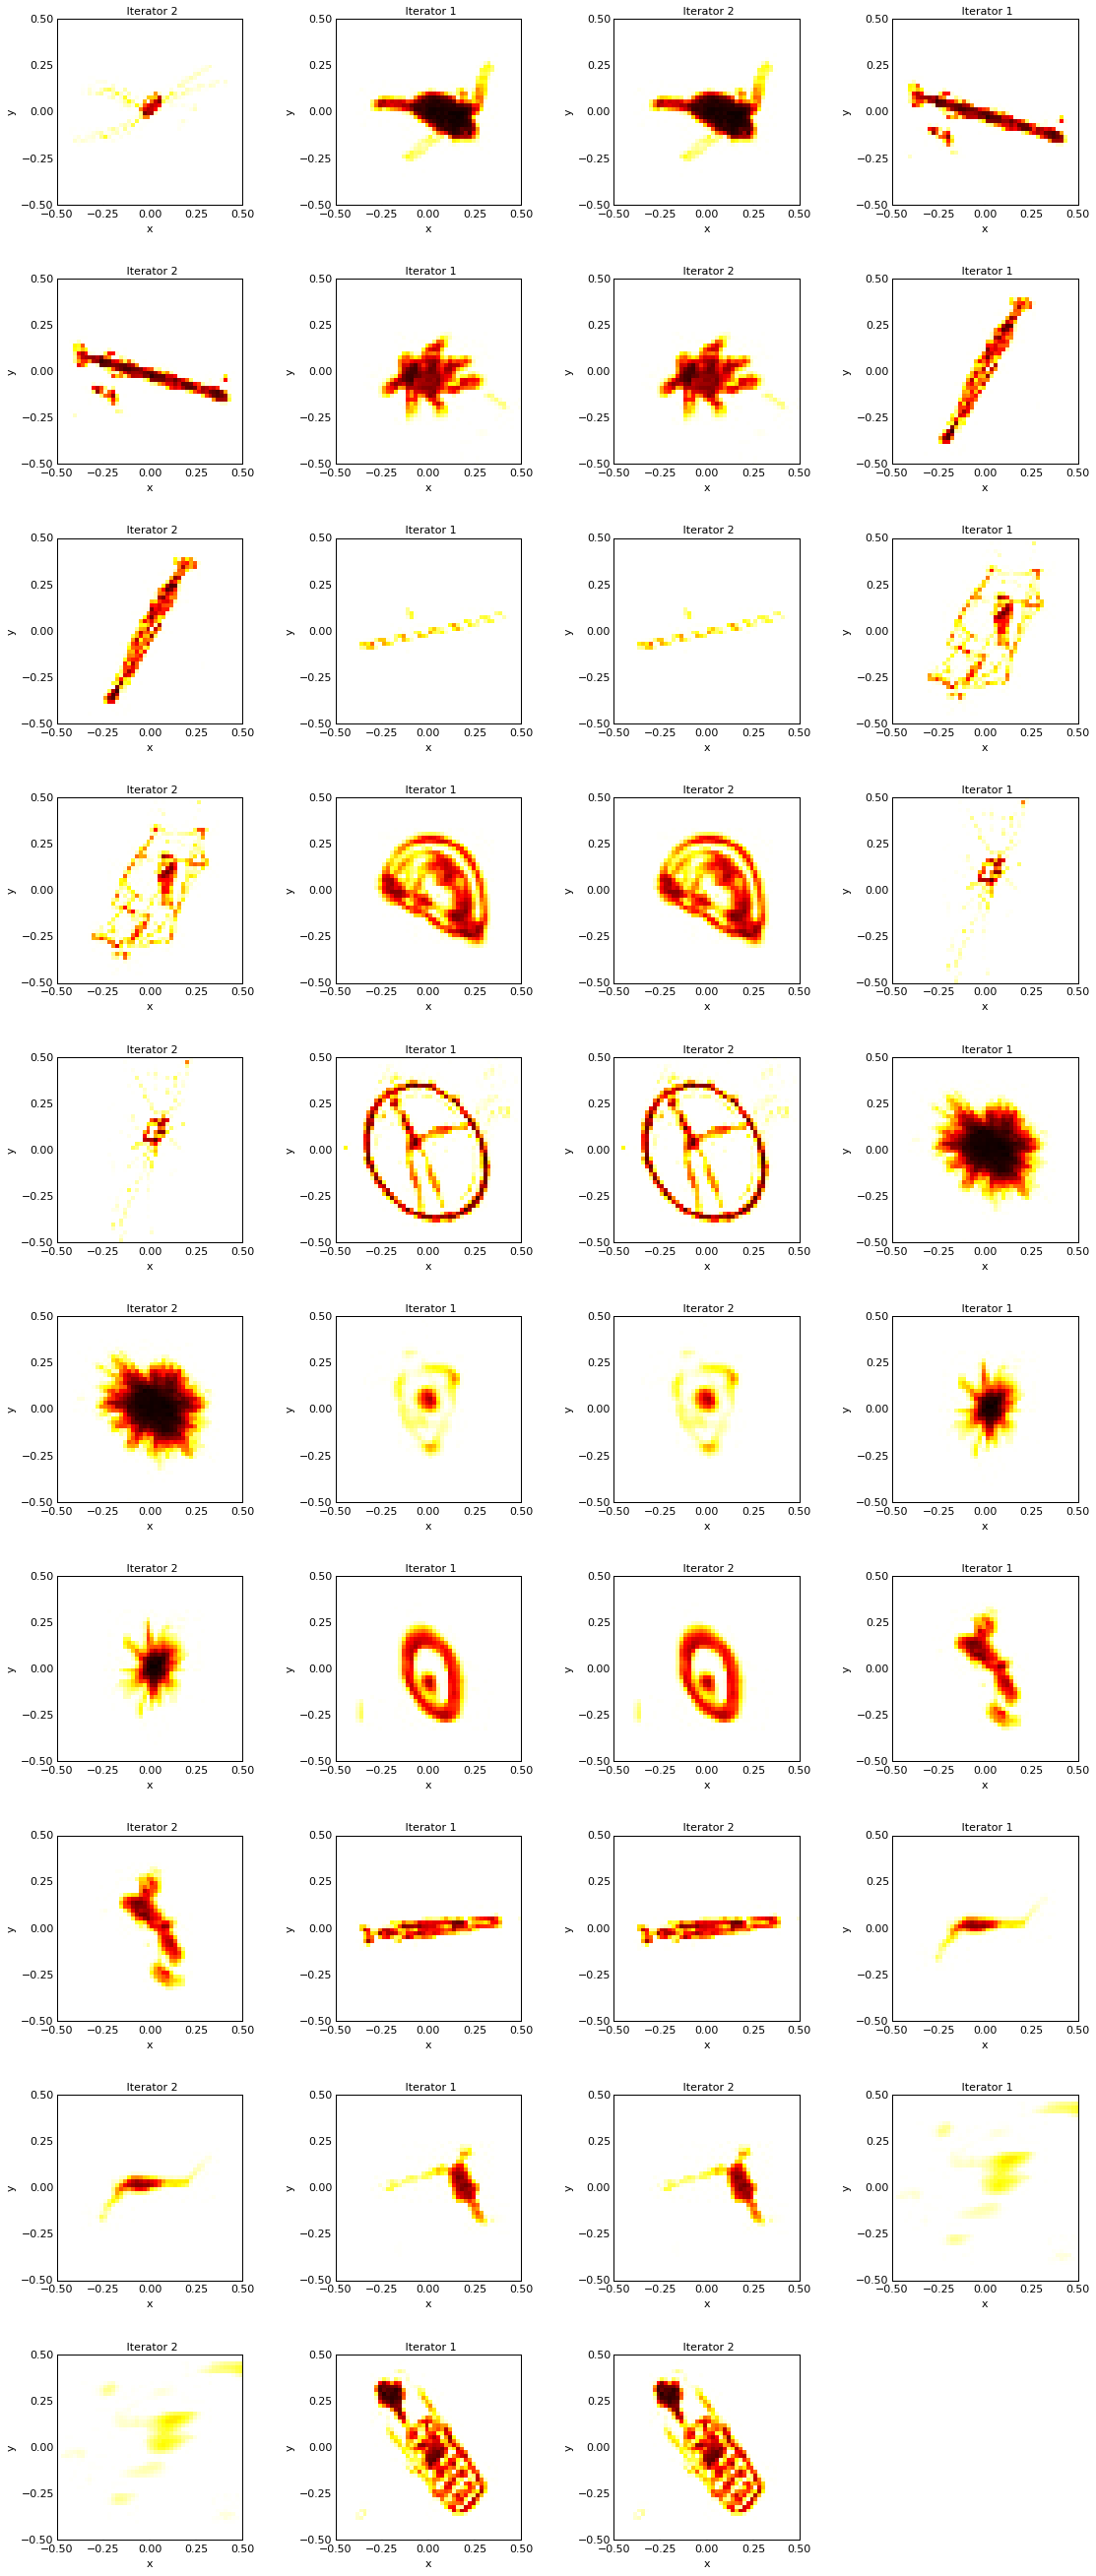

In [22]:
channels = None
for i in range(20):
    if not channels:
        channels = hl.Image(X1[i,:].squeeze(),group="Iterator 1")
        channels = hl.Image(X2[i,:].squeeze(),group="Iterator 2")
    else:
        channels += hl.Image(X1[i,:].squeeze(),group="Iterator 1")
        channels += hl.Image(X2[i,:].squeeze(),group="Iterator 2")
channels

Don't know why there's a single one from Iterator 2 at the start, but otherwise seems to have worked.

Creating the rest
---------------

The rest of the train object stays the same, apart from the save path and that the algorithm will have to load one of these new ParallelDataset objects for its validation set. So, we're missing:

* __algorithm__ - contains validation set, which must be set up as a parallel dataset.
* __extensions__ - keeping these the same but changing save paths

It's worth noting that when we define the cost and the weight decay we have to address the new convolutional layers inside the composite layer.

In [23]:
import pylearn2.training_algorithms.sgd
import pylearn2.costs.mlp.dropout
import pylearn2.costs.cost
import pylearn2.termination_criteria

In [24]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':ParallelDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.cost.SumOfCosts(
            costs=[
                pylearn2.costs.mlp.dropout.Dropout(
                    input_include_probs={'h5':0.5},
                    input_scales={'h5':2.0}),
                pylearn2.costs.mlp.WeightDecay(coeffs={'parallel_conv':0.00005,
                                                'h5':0.00005})
            ]
        ),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=500)
    )

In [25]:
import pylearn2.train_extensions
import pylearn2.train_extensions.best_params

In [26]:
extensions = [
    pylearn2.training_algorithms.learning_rule.MomentumAdjustor(
        start=1,
        saturate=200,
        final_momentum=0.95
    ),
    pylearn2.training_algorithms.sgd.LinearDecayOverEpoch(
        start=1,
        saturate=200,
        decay_factor=0.025
    ),
    pylearn2.train_extensions.best_params.MonitorBasedSaveBest(
        channel_name='valid_y_nll',
        save_path='/disk/scratch/neuroglycerin/models/parallel_interactive.pkl'
    ),
    pylearn2.training_algorithms.sgd.MonitorBasedLRAdjuster(
        high_trigger=1.0,
        low_trigger=0.999,
        grow_amt=1.012,
        shrink_amt=0.986,
        max_lr=0.4,
        min_lr=0.00005,
        channel_name='valid_y_nll'
    )
]

Assembling the full train object
===========

We now have everything we need to make up our train object, so we can put it together and see how well it runs.

In [27]:
import pylearn2.train

In [28]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    extensions=extensions,
    save_path='/disk/scratch/neuroglycerin/models/parallel_interactive_recent.pkl',
    save_freq=1
)

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/pylearn2/pylearn2/train.py:85: UserWarning: dataset has no yaml src, model won't know what data it was trained on
  "data it was trained on")


We can live with that warning. 

Now, attempting to run the model:

In [29]:
train.main_loop()

Parameter and initial learning rate summary:
	h1_W: 0.10000000149
	h1_b: 0.10000000149
	h2_W: 0.10000000149
	h2_b: 0.10000000149
	h3_W: 0.10000000149
	h3_b: 0.10000000149
	h4_W: 0.10000000149
	h4_b: 0.10000000149
	h1_W: 0.10000000149
	h1_b: 0.10000000149
	h2_W: 0.10000000149
	h2_b: 0.10000000149
	h3_W: 0.10000000149
	h3_b: 0.10000000149
	h4_W: 0.10000000149
	h4_b: 0.10000000149
	h5_W: 0.0250000003725
	h5_b: 0.0250000003725
	softmax_b: 0.0250000003725
	softmax_W: 0.0250000003725
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 11.324222 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 2.091163 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h5_col_norms_max
	train_h5_col_norms_mean
	train_h5_col_norms_min
	train_h5_max_x_max_u
	train_h5_max_x_mean_u
	train_h5_max_x_min_u
	train_h5_mean_x_max_u
	train_h5_mean_x_mean_u
	train_h5_mean_x_min_u
	train_h5_min_x_max_u
	train_h5_min_x_mean_u
	train_h5

ERROR (theano.gof.opt): SeqOptimizer apply MergeOptimizer
ERROR:theano.gof.opt:SeqOptimizer apply MergeOptimizer
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/opt.py", line 195, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/opt.py", line 81, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/opt.py", line 621, in apply
    fgraph.replace_all_validate(pairs, 'MergeOptimizer')
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/toolbox.py", line 258, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/fg.py", line 467, in replace
    raise TypeError("The type of the replacement must b

graph size: 1158
graph size: 1154
Compiling accum done. Time elapsed: 0:01:04.146942
Monitoring step:
	Epochs seen: 0
	Batches seen: 0
	Examples seen: 0
	learning_rate: 0.100000113249
	momentum: 0.49999922514
	total_seconds_last_epoch: 0.0
	train_h5_col_norms_max: 0.899228215218
	train_h5_col_norms_mean: 0.799151003361
	train_h5_col_norms_min: 0.698729097843
	train_h5_max_x_max_u: 0.0475132316351
	train_h5_max_x_mean_u: 0.00929783005267
	train_h5_max_x_min_u: 0.0
	train_h5_mean_x_max_u: 0.0284981485456
	train_h5_mean_x_mean_u: 0.0038538640365
	train_h5_mean_x_min_u: 0.0
	train_h5_min_x_max_u: 0.0127027221024
	train_h5_min_x_mean_u: 0.000834370497614
	train_h5_min_x_min_u: 0.0
	train_h5_range_x_max_u: 0.0374712385237
	train_h5_range_x_mean_u: 0.00846346281469
	train_h5_range_x_min_u: 0.0
	train_h5_row_norms_max: 1.68889701366
	train_h5_row_norms_mean: 1.59945118427
	train_h5_row_norms_min: 1.51121270657
	train_objective: 4.83721733093
	train_parallel_conv_convlayer_0_h1_kernel_norms_max

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/pylearn2/pylearn2/monitor.py:573: UserWarning: Trained model saved without indicating yaml_src
  'indicating yaml_src')


Time this epoch: 0:04:09.848298
Monitoring step:
	Epochs seen: 1
	Batches seen: 189
	Examples seen: 24192
	learning_rate: 0.0995122715831
	momentum: 0.49999922514
	total_seconds_last_epoch: 0.0
	train_h5_col_norms_max: 0.906052649021
	train_h5_col_norms_mean: 0.798457682133
	train_h5_col_norms_min: 0.698196172714
	train_h5_max_x_max_u: 1.09047603607
	train_h5_max_x_mean_u: 0.199399873614
	train_h5_max_x_min_u: 0.0
	train_h5_mean_x_max_u: 0.761857151985
	train_h5_mean_x_mean_u: 0.0910970792174
	train_h5_mean_x_min_u: 0.0
	train_h5_min_x_max_u: 0.406227201223
	train_h5_min_x_mean_u: 0.0217617247254
	train_h5_min_x_min_u: 0.0
	train_h5_range_x_max_u: 0.898805439472
	train_h5_range_x_mean_u: 0.177638217807
	train_h5_range_x_min_u: 0.0
	train_h5_row_norms_max: 1.68716108799
	train_h5_row_norms_mean: 1.59806966782
	train_h5_row_norms_min: 1.51398015022
	train_objective: 3.93358445168
	train_parallel_conv_convlayer_0_h1_kernel_norms_max: 0.295005738735
	train_parallel_conv_convlayer_0_h1_kern

KeyboardInterrupt: 